<a href="https://colab.research.google.com/github/fnoritomi/projeto_sih/blob/main/sih_dengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Regressão Linear com a base reduzida do SIH

## Instalação da biblioteca PySUS

[https://github.com/AlertaDengue/PySUS](https://github.com/AlertaDengue/PySUS)

In [ ]:
!sudo apt install libffi-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libffi-dev
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 63.7 kB of archives.
After this operation, 336 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libffi-dev amd64 3.4.2-4 [63.7 kB]
Fetched 63.7 kB in 0s (344 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libffi-dev:amd64.
(Reading database ... 124926 files and directori

In [ ]:
!sudo pip install PySUS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

## Carregamento das bibliotecas e configurações do Notebook

In [ ]:
from pysus.ftp.databases.sih import SIH

In [410]:
import pandas as pd
import duckdb
import os
import shutil
from google.colab import files
from google.colab import drive

# Monta o Google Drive no Workspace do Notebook
drive.mount('/content/drive')

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_info_columns', 200)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download de arquivos do SIH

In [ ]:
sih = SIH().load() # Carrega lista de arquivos do DATASUS
files = sih.get_files("RD", uf="DF", year=[ano for ano in range(2020, 2025)])
sih_files = sih.download(files)

In [ ]:
pasta_destino = '/content/drive/MyDrive/Colab Notebooks/Dados/sih'

for pasta in [str(parquet) for parquet in sih_files]:
  nome_pasta = os.path.basename(pasta)  # Extrai o nome da pasta do caminho completo
  destino = os.path.join(pasta_destino, nome_pasta)  # Cria o caminho de destino
  if os.path.exists(destino):  # Verifica se a pasta de destino já existe
    shutil.rmtree(destino)  # Remove a pasta de destino e seu conteúdo
  if os.path.exists(pasta):
    shutil.move(pasta, pasta_destino)  # Move a pasta e seu conteúdo, sobrescrevendo se existir

## Carga de dados de internações por dengue no DF

In [5]:
def sql_query(query):
  return duckdb.sql(query).df()

In [414]:
query = f"""
  SELECT ANO_CMPT::INT as ano,
    MES_CMPT::INT as mes,
    ESPEC as cd_especialidade,
    -- CGC_HOSP,
    --N_AIH,
    --IDENT,
    --CEP,
    MUNIC_RES as cd_municipio_res,
    --NASC,
    SEXO as cd_sexo,
    --UTI_MES_IN, UTI_MES_AN, UTI_MES_AL,
    UTI_MES_TO::INT as qt_diarias_uti,
    MARCA_UTI as cd_tipo_uti,
    --UTI_INT_IN, UTI_INT_AN, UTI_INT_AL,
    UTI_INT_TO::INT as qt_diarias_uti_interm,
    DIAR_ACOM::INT as qt_diarias_acompanhante,
    QT_DIARIAS::INT as qt_diarias,
    PROC_SOLIC as cd_proc_solicitado,
    PROC_REA as cd_proc_realizado,
    VAL_SH::DECIMAL(15, 2) as vl_sh,
    VAL_SP::DECIMAL(15, 2) as vl_sp,
    --VAL_SADT, VAL_RN, VAL_ACOMP, VAL_ORTP, VAL_SANGUE, VAL_SADTSR, VAL_TRANSP, VAL_OBSANG, VAL_PED1AC,
    VAL_TOT::DECIMAL(15, 2) as vl_total,
    VAL_UTI::DECIMAL(15, 2) as vl_uti,
    --US_TOT,
    strptime(DT_INTER, '%Y%m%d') as dt_internacao,
    strptime(DT_SAIDA, '%Y%m%d') as dt_saida,
    TRIM(DIAG_PRINC) as cd_diag_princ,
    --DIAG_SECUN,
    COBRANCA as cd_motivo_alta_perm,
    --NATUREZA,
    NAT_JUR as cd_natureza_juridica,
    --GESTAO,
    --RUBRICA,
    --IND_VDRL,
    MUNIC_MOV as cd_municipio_estab,
    COD_IDADE as cd_unidade_idade,
    IDADE as idade,
    DIAS_PERM::INT as qt_dias_permanencia,
    MORTE as cd_morte,
    NACIONAL as cd_nacionalidade,
    --NUM_PROC,
    CAR_INT as cd_carater_atendimento,
    --TOT_PT_SP,
    --CPF_AUT,
    --HOMONIMO,
    --NUM_FILHOS,
    --INSTRU,
    --CID_NOTIF,
    --CONTRACEP1,
    --CONTRACEP2,
    --GESTRISCO,
    --INSC_PN,
    --SEQ_AIH5,
    --CBOR, CNAER, VINCPREV,
    --GESTOR_COD, GESTOR_TP, GESTOR_CPF, GESTOR_DT,
    CNES cd_cnes,
    --CNPJ_MANT, INFEHOSP,
    --CID_ASSO,
    --CID_MORTE,
    COMPLEX AS cd_complexidade,
    FINANC AS cd_tipo_financiamento,
    --FAEC_TP, REGCT,
    RACA_COR cd_raca_cor,
    --ETNIA,
    --SEQUENCIA, REMESSA, AUD_JUST, SIS_JUST,
    --VAL_SH_FED, VAL_SP_FED, VAL_SH_GES, VAL_SP_GES,
    --VAL_UCI, MARCA_UCI,
    --DIAGSEC1, DIAGSEC2, DIAGSEC3, DIAGSEC4, DIAGSEC5, DIAGSEC6, DIAGSEC7, DIAGSEC8, DIAGSEC9,
    --TPDISEC1, TPDISEC2, TPDISEC3, TPDISEC4, TPDISEC5, TPDISEC6, TPDISEC7, TPDISEC8, TPDISEC9
  FROM parquet_scan('/content/drive/MyDrive/Colab Notebooks/Dados/sih/*/*.parquet')
  WHERE TRIM(DIAG_PRINC) IN ('A90', 'A91')
    OR PROC_REA IN ('0303010010', '0303010029')
  """
dengue_df = sql_query(query)

In [415]:
dengue_df.head()

ano  mes cd_especialidade cd_municipio_res cd_sexo  qt_diarias_uti cd_tipo_uti  qt_diarias_uti_interm  qt_diarias_acompanhante  qt_diarias cd_proc_solicitado cd_proc_realizado   vl_sh  vl_sp  vl_total  vl_uti dt_internacao   dt_saida cd_diag_princ cd_motivo_alta_perm cd_natureza_juridica cd_municipio_estab cd_unidade_idade idade  qt_dias_permanencia cd_morte cd_nacionalidade cd_carater_atendimento  cd_cnes cd_complexidade cd_tipo_financiamento cd_raca_cor
0  2020    1               07           520025       3               0          00                      0                        3           3         0303010010        0303010010  253.44  58.32    311.76     0.0    2020-01-14 2020-01-17           A90                  12                 1023             530010                4     2                    3        0              010                     02  0010545              02                    06          03
1  2020    1               03           530010       3               0          00                      0                        0           3         0303010010        0303010010  367.65  78.73    446.38     0.0    2020-01-26 2020-01-29           A90                  15                 1023             530010                4    30                    3        0              010                     02  0010499              02                    06          01
2  2020    1               03           530010       3               0          00                      0                        3           4         0303010010        0303010010  253.44  58.32    311.76     0.0    2019-10-11 2019-10-14           A90                  26                 1023             530010                4    94                    3        0              010                     02  0010529              02                    06          99
3  2020    1               03           530010       3               0          00                      0                        2           2         0303010010        0303010010  245.44  58.32    303.76     0.0    2020-01-02 2020-01-04           A90                  16                 1023             530010                4    71                    2        0              010                     02  0010545              02                    06          01
4  2020    1               03           521560       3               0          00                      0                        0           2         0303010010        0303010010  229.44  58.32    287.76     0.0    2020-01-27 2020-01-29           A90                  18                 1023             530010                4    39                    2        0              010                     02  0010545              02                    06          01

In [416]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ano                      12330 non-null  int32         
 1   mes                      12330 non-null  int32         
 2   cd_especialidade         12330 non-null  object        
 3   cd_municipio_res         12330 non-null  object        
 4   cd_sexo                  12330 non-null  object        
 5   qt_diarias_uti           12330 non-null  int32         
 6   cd_tipo_uti              12330 non-null  object        
 7   qt_diarias_uti_interm    12330 non-null  int32         
 8   qt_diarias_acompanhante  12330 non-null  int32         
 9   qt_diarias               12330 non-null  int32         
 10  cd_proc_solicitado       12330 non-null  object        
 11  cd_proc_realizado        12330 non-null  object        
 12  vl_sh                    12330 n

## Inclusão das descrições dos valores do campos categóricos

In [417]:
especialidades = {
  '01': 'Cirurgia',
  '02': 'Obstetrícia',
  '03': 'Clínica médica',
  '04': 'Crônicos',
  '05': 'Psiquiatria',
  '06': 'Pneumologia sanitária',
  '07': 'Pediatria',
  '08': 'Reabilitação',
  '09': 'Hospital dia (cirúrgicos)',
  '10': 'Hospital dia (AIDS)',
  '11': 'Hospital dia (fibrose cística)',
  '12': 'Hospital dia (intercorrência pós transplantes)',
  '13': 'Hospital dia (geriatria)',
  '14': 'Hospital dia (saúde mental)'
}

dengue_df['especialidade']=dengue_df.cd_especialidade.replace(especialidades)
dengue_df.especialidade.value_counts()

especialidade
Clínica médica    6952
Pediatria         5372
Cirurgia             6
Name: count, dtype: int64

In [418]:
sexos = {
  '1': 'Masculino',
  '2': 'Feminino',
  '3': 'Feminino',
  '0': 'NA',
  '9': 'NA'
}
dengue_df['sexo']=dengue_df.cd_sexo.replace(sexos)
dengue_df.sexo.value_counts()

sexo
Feminino     6502
Masculino    5828
Name: count, dtype: int64

In [419]:
dengue_df['lg_masculino']=dengue_df.cd_sexo.apply(lambda x: 1 if x == '1' else 0)
dengue_df.lg_masculino.value_counts()

lg_masculino
0    6502
1    5828
Name: count, dtype: int64

In [420]:
tipos_utis = {
  '00': 'Não utilizou UTI',
  '74': 'UTI adulto - tipo I',
  '75': 'UTI adulto - tipo II',
  '76': 'UTI adulto - tipo III',
  '77': 'UTI infantil - tipo I',
  '78': 'UTI infantil - tipo II',
  '79': 'UTI infantil - tipo III',
  '80': 'UTI neonatal - tipo I',
  '81': 'UTI neonatal - tipo II',
  '82': 'UTI neonatal - tipo III',
  '83': 'UTI de queimados',
  '85': 'UTI coronariana tipo II - UCO tipo II',
  '86': 'UTI coronariana tipo III - UCO tipo III',
  '99': 'UTI Doador',
  '01': 'Utilizou mais de um tipo de UTI'
}

dengue_df['tipo_uti']=dengue_df.cd_tipo_uti.replace(tipos_utis)
dengue_df.tipo_uti.value_counts()

tipo_uti
Não utilizou UTI                   11614
UTI adulto - tipo II                 536
UTI infantil - tipo II               150
UTI infantil - tipo III               15
UTI neonatal - tipo II                 7
UTI adulto - tipo III                  5
51                                     1
UTI neonatal - tipo III                1
Utilizou mais de um tipo de UTI        1
Name: count, dtype: int64

In [421]:
motivos_alta_perm = {
  '11': 'Alta curado',
  '12': 'Alta melhorado',
  '14': 'Alta a pedido',
  '15': 'Alta com previsão de retorno p/acomp do paciente',
  '16': 'Alta por evasão',
  '18': 'Alta por outros motivos',
  '19': 'Alta de paciente agudo em psiquiatria',
  '21': 'Permanência por características próprias da doença',
  '22': 'Permanência por intercorrência',
  '23': 'Permanência por impossibilidade sócio-familiar',
  '24': 'Permanência proc doação órg, tec, cél-doador vivo',
  '25': 'Permanência proc doação órg, tec, cél-doador morto',
  '26': 'Permanência por mudança de procedimento',
  '27': 'Permanência por reoperação',
  '28': 'Permanência por outros motivos',
  '29': 'Transferência para internação domiciliar',
  '32': 'Transferência para internação domiciliar',
  '31': 'Transferência para outro estabelecimento',
  '41': 'Óbito com DO fornecida pelo médico assistente',
  '42': 'Óbito com DO fornecida pelo IML',
  '43': 'Óbito com DO fornecida pelo SVO',
  '51': 'Encerramento administrativo',
  '61': 'Alta da mãe/puérpera e do recém-nascido',
  '17': 'Alta da mãe/puérpera e do recém-nascido',
  '62': 'Alta da mãe/puérpera e permanência recém-nascido',
  '13': 'Alta da mãe/puérpera e permanência recém-nascido',
  '63': 'Alta da mãe/puérpera e óbito do recém-nascido',
  '64': 'Alta da mãe/puérpera com óbito fetal',
  '65': 'Óbito da gestante e do concepto',
  '66': 'Óbito da mãe/puérpera e alta do recém-nascido',
  '67': 'Óbito da mãe/puérpera e permanência recém-nascido'
}

dengue_df['motivo_alta_perm']=dengue_df.cd_motivo_alta_perm.replace(motivos_alta_perm)
dengue_df.motivo_alta_perm.value_counts()

motivo_alta_perm
Alta melhorado                                        8797
Alta com previsão de retorno p/acomp do paciente      1755
Transferência para outro estabelecimento               700
Alta por outros motivos                                283
Alta por evasão                                        267
Óbito com DO fornecida pelo médico assistente          142
Permanência por mudança de procedimento                108
Alta curado                                             72
Permanência por intercorrência                          56
Encerramento administrativo                             50
Alta a pedido                                           36
Óbito com DO fornecida pelo IML                         27
Permanência por outros motivos                          23
Permanência por características próprias da doença      10
Óbito com DO fornecida pelo SVO                          3
Permanência por reoperação                               1
Name: count, dtype: int64

In [422]:
naturezas_juridicas = {
  '1015':"Órgão Público do Poder Executivo Federal",
  '1023':"Órgão Público do Poder Exec Estadual ou Distr Fed",
  '1031':"Órgão Público do Poder Executivo Municipal",
  '1040':"Órgão Público do Poder Legislativo Federal",
  '1058':"Órgão Público do Poder Legisl Estadual ou Dist Fed",
  '1066':"Órgão Público do Poder Legislativo Municipal",
  '1074':"Órgão Público do Poder Judiciário Federal",
  '1082':"Órgão Público do Poder Judiciário Estadual",
  '1104':"Autarquia Federal",
  '1112':"Autarquia Estadual ou do Distrito Federal",
  '1120':"Autarquia Municipal",
  '1139':"Fundação Federal",
  '1147':"Fundação Estadual ou do Distrito Federal",
  '1155':"Fundação Municipal",
  '1163':"Órgão Público Autônomo Federal",
  '1171':"Órgão Público Autônomo Estadual ou Distr Federal",
  '1180':"Órgão Público Autônomo Estadual ou Distr Federal",
  '1198':"Comissão Polinacional",
  '1201':"Fundo Público",
  '1210':"Associação Pública",
  '2011':"Empresa Pública",
  '2038':"Sociedade de Economia Mista",
  '2046':"Sociedade Anônima Aberta",
  '2054':"Sociedade Anônima Fechada",
  '2062':"Sociedade Empresária Limitada",
  '2070':"Sociedade Empresária em Nome Coletivo",
  '2089':"Sociedade Empresária em Comandita Simples",
  '2097':"Sociedade Empresária em Comandita por Ações",
  '2127':"Sociedade em Conta de Participação",
  '2135':"Empresário (Individual)",
  '2143':"Cooperativa",
  '2151':"Consórcio de Sociedades",
  '2160':"Grupo de Sociedades",
  '2178':"Estabelecimento no Brasil de Sociedade Estrangeira",
  '2194':"Estab no Brasil Empr Binacional Argentina-Brasil",
  '2216':"Empresa Domiciliada no Exterior",
  '2224':"Clube/Fundo de Investimento",
  '2232':"Sociedade Simples Pura",
  '2240':"Sociedade Simples Limitada",
  '2259':"Sociedade Simples em Nome Coletivo",
  '2267':"Sociedade Simples em Comandita Simples",
  '2275':"Empresa Binacional",
  '2283':"Consórcio de Empregadores",
  '2291':"Consórcio Simples",
  '2305':"Empr Individ Responsab Limitada (Natur Empresária)",
  '2313':"Empr Individ Responsab Limitada (Natureza Simples)",
  '3034':"Serviço Notarial e Registral (Cartório)",
  '3069':"Fundação Privada",
  '3077':"Serviço Social Autônomo",
  '3085':"Condomínio Edilício",
  '3107':"Comissão de Conciliação Prévia",
  '3115':"Entidade de Mediação e Arbitragem",
  '3123':"Partido Político",
  '3131':"Entidade Sindical",
  '3204':"Estab no Brasil de Fundação ou Associação Estrang",
  '3212':"Fundação ou Associação Domiciliada no Exterior",
  '3220':"Organização Religiosa",
  '3239':"Comunidade Indígena",
  '3247':"Fundo Privado",
  '3999':"Associação Privada",
  '4014':"Empresa Individual Imobiliária",
  '4022':"Segurado Especial",
  '4081':"Contribuinte Individual",
  '4090':"Candidato a Cargo Político Eletivo",
  '4111':"Leiloeiro",
  '5010':"Organização Internacional",
  '5029':"Representação Diplomática Estrangeira",
  '5037':"Outras Instituições Extraterritoriais",
  '0000':""
}

dengue_df['natureza_juridica']=dengue_df.cd_natureza_juridica.replace(naturezas_juridicas)
dengue_df.natureza_juridica.value_counts()

natureza_juridica
Órgão Público do Poder Exec Estadual ou Distr Fed    8404
Serviço Social Autônomo                              3164
Fundação Federal                                      305
Sociedade Empresária Limitada                         159
Fundação Estadual ou do Distrito Federal              118
Sociedade Anônima Fechada                              94
Associação Privada                                     84
Fundação Privada                                        2
Name: count, dtype: int64

In [423]:
dengue_df['lg_estab_publico']=dengue_df.cd_natureza_juridica.apply(lambda x: 1 if x[0]=='1' else 0)
dengue_df.lg_estab_publico.value_counts()

lg_estab_publico
1    8827
0    3503
Name: count, dtype: int64

In [424]:
dengue_df['lg_empresa']=dengue_df.cd_natureza_juridica.apply(lambda x: 1 if x[0]=='2' else 0)
dengue_df.lg_empresa.value_counts()

lg_empresa
0    12077
1      253
Name: count, dtype: int64

In [425]:
unidades_idade = {
  "2": "Dias",
  "3": "Meses",
  "4": "Anos",
  "5": "Anos a partir de 100",
  "0": ""
}
dengue_df['unidade_idade']=dengue_df.cd_unidade_idade.replace(unidades_idade)
dengue_df.unidade_idade.value_counts()

unidade_idade
Anos                    11694
Meses                     577
Dias                       56
Anos a partir de 100        3
Name: count, dtype: int64

In [426]:
def calcula_idade_anos(cd_unidade_idade, idade):
  if cd_unidade_idade == '2':
    return float(idade)/365
  elif cd_unidade_idade == '3':
    return float(idade)/12
  elif cd_unidade_idade == '4':
    return float(idade)
  elif cd_unidade_idade == '5':
    return 100 + float(idade)

dengue_df['idade_anos']=dengue_df[['cd_unidade_idade', 'idade']].apply(lambda x: calcula_idade_anos(x.cd_unidade_idade, x.idade), axis=1)

In [427]:
dengue_df.idade_anos.describe()

count    12330.000000
mean        29.663824
std         25.458155
min          0.010959
25%          8.000000
50%         22.000000
75%         50.000000
max        105.000000
Name: idade_anos, dtype: float64

In [428]:
morte = {
  '00': 0,
  '01': 1
}
dengue_df['lg_morte']=dengue_df.cd_morte.replace(morte).apply(int)
dengue_df.lg_morte.value_counts()


lg_morte
0    12158
1      172
Name: count, dtype: int64

In [429]:
dengue_df['lg_brasileiro']=dengue_df.cd_nacionalidade.apply(lambda x: 1 if x == '010' else 0)
dengue_df.lg_brasileiro.value_counts()

lg_brasileiro
1    12301
0       29
Name: count, dtype: int64

In [430]:
carateres_atedimento = {
  '01': 'Eletivo',
  '02': 'Urgência',
  '03': 'Acidente no local trabalho ou a serv da empresa',
  '04': 'Acidente no trajeto para o trabalho',
  '05': 'Outros tipo de acidente de trânsito',
  '06': 'Outros tipos de lesões'
}
dengue_df['carater_atendimento']=dengue_df.cd_carater_atendimento.replace(carateres_atedimento)
dengue_df.carater_atendimento.value_counts()

carater_atendimento
Urgência    12166
Eletivo       164
Name: count, dtype: int64

In [431]:
complexidades = {
  '01': 'Atenção básica',
  '02': 'Média complexidade',
  '03': 'Alta complexidade'
}
dengue_df['complexidade']=dengue_df.cd_complexidade.replace(complexidades)
dengue_df.complexidade.value_counts()

complexidade
Média complexidade    12318
Alta complexidade        12
Name: count, dtype: int64

In [432]:
tipos_financiamento = {
  '01': 'Atenção Básica (PAB)',
  '02': 'Assistência Farmacêutica',
  '04': 'Fundo de Ações Estratégicas (FAEC)',
  '05': 'Incentivo - MAC',
  '06': 'Média e Alta Complexidade (MAC)',
  '07': 'Vigilância em Saúde',
  '00': 'NA',
  '09': 'NA'
}
dengue_df['tipo_financiamento']=dengue_df.cd_tipo_financiamento.replace(tipos_financiamento)
dengue_df.tipo_financiamento.value_counts()

tipo_financiamento
Média e Alta Complexidade (MAC)       12319
Fundo de Ações Estratégicas (FAEC)       11
Name: count, dtype: int64

In [433]:
racas_cores = {
  '01': 'Branca',
  '02': 'Preta',
  '03': 'Parda',
  '04': 'Amarela',
  '05': 'Indígena',
  '00': 'NA',
  '99': 'NA'
}
dengue_df['raca_cor']=dengue_df.cd_raca_cor.replace(racas_cores)
dengue_df.raca_cor.value_counts()

raca_cor
Parda      8004
Branca     2437
NA         1387
Preta       421
Amarela      81
Name: count, dtype: int64

In [434]:
dengue_df['lg_preta']=dengue_df.cd_raca_cor.apply(lambda x: 1 if x == '02' else 0)
dengue_df.lg_preta.value_counts()

lg_preta
0    11909
1      421
Name: count, dtype: int64

In [435]:
dengue_df['lg_mesmo_municipio']=dengue_df[['cd_municipio_res', 'cd_municipio_estab']].apply(lambda x: 1 if x.cd_municipio_res == x.cd_municipio_estab else 0, axis=1)
dengue_df.lg_mesmo_municipio.value_counts()

lg_mesmo_municipio
1    10797
0     1533
Name: count, dtype: int64

In [436]:
dengue_df['lg_hemorragica']=dengue_df[['cd_diag_princ', 'cd_proc_realizado']].apply(
    lambda x: 1 if ((x.cd_diag_princ == 'A91') | (x.cd_proc_realizado == '0303010029')) else 0, axis = 1
    )
dengue_df.lg_hemorragica.value_counts()

lg_hemorragica
0    11624
1      706
Name: count, dtype: int64

In [437]:
dengue_df[['cd_diag_princ', 'cd_proc_realizado']]

cd_diag_princ cd_proc_realizado
0               A90        0303010010
1               A90        0303010010
2               A90        0303010010
3               A90        0303010010
4               A90        0303010010
...             ...               ...
12325           A90        0303010010
12326           A90        0301060010
12327           A90        0301060010
12328           A90        0301060010
12329           A90        0301060010

[12330 rows x 2 columns]

In [439]:
dengue_df.head()

ano  mes cd_especialidade cd_municipio_res cd_sexo  qt_diarias_uti cd_tipo_uti  qt_diarias_uti_interm  qt_diarias_acompanhante  qt_diarias cd_proc_solicitado cd_proc_realizado   vl_sh  vl_sp  vl_total  vl_uti dt_internacao   dt_saida cd_diag_princ cd_motivo_alta_perm cd_natureza_juridica cd_municipio_estab cd_unidade_idade idade  qt_dias_permanencia cd_morte cd_nacionalidade cd_carater_atendimento  cd_cnes cd_complexidade cd_tipo_financiamento cd_raca_cor   especialidade      sexo  lg_masculino          tipo_uti                                  motivo_alta_perm                                  natureza_juridica  lg_estab_publico  lg_empresa unidade_idade  idade_anos  lg_morte  lg_brasileiro carater_atendimento        complexidade               tipo_financiamento raca_cor  lg_preta  lg_mesmo_municipio  lg_hemorragica
0  2020    1               07           520025       3               0          00                      0                        3           3         0303010010        0303010010  253.44  58.32    311.76     0.0    2020-01-14 2020-01-17           A90                  12                 1023             530010                4     2                    3        0              010                     02  0010545              02                    06          03       Pediatria  Feminino             0  Não utilizou UTI                                    Alta melhorado  Órgão Público do Poder Exec Estadual ou Distr Fed                 1           0          Anos         2.0         0              1            Urgência  Média complexidade  Média e Alta Complexidade (MAC)    Parda         0                   0               0
1  2020    1               03           530010       3               0          00                      0                        0           3         0303010010        0303010010  367.65  78.73    446.38     0.0    2020-01-26 2020-01-29           A90                  15                 1023             530010                4    30                    3        0              010                     02  0010499              02                    06          01  Clínica médica  Feminino             0  Não utilizou UTI  Alta com previsão de retorno p/acomp do paciente  Órgão Público do Poder Exec Estadual ou Distr Fed                 1           0          Anos        30.0         0              1            Urgência  Média complexidade  Média e Alta Complexidade (MAC)   Branca         0                   1               0
2  2020    1               03           530010       3               0          00                      0                        3           4         0303010010        0303010010  253.44  58.32    311.76     0.0    2019-10-11 2019-10-14           A90                  26                 1023             530010                4    94                    3        0              010                     02  0010529              02                    06          99  Clínica médica  Feminino             0  Não utilizou UTI           Permanência por mudança de procedimento  Órgão Público do Poder Exec Estadual ou Distr Fed                 1           0          Anos        94.0         0              1            Urgência  Média complexidade  Média e Alta Complexidade (MAC)       NA         0                   1               0
3  2020    1               03           530010       3               0          00                      0                        2           2         0303010010        0303010010  245.44  58.32    303.76     0.0    2020-01-02 2020-01-04           A90                  16                 1023             530010                4    71                    2        0              010                     02  0010545              02                    06          01  Clínica médica  Feminino             0  Não utilizou UTI                                   Alta por evasão  Órgão Público do Poder Exec Estadual ou Distr Fed                 1           0          Anos        71

In [440]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ano                      12330 non-null  int32         
 1   mes                      12330 non-null  int32         
 2   cd_especialidade         12330 non-null  object        
 3   cd_municipio_res         12330 non-null  object        
 4   cd_sexo                  12330 non-null  object        
 5   qt_diarias_uti           12330 non-null  int32         
 6   cd_tipo_uti              12330 non-null  object        
 7   qt_diarias_uti_interm    12330 non-null  int32         
 8   qt_diarias_acompanhante  12330 non-null  int32         
 9   qt_diarias               12330 non-null  int32         
 10  cd_proc_solicitado       12330 non-null  object        
 11  cd_proc_realizado        12330 non-null  object        
 12  vl_sh                    12330 n

In [441]:
dengue_df.groupby('ano')['vl_total'].agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

count         sum    min       max        mean          std
ano                                                              
2020    994   434196.47  44.22  23613.34  436.817374   958.097858
2021    436   177170.33  44.22  19017.10  406.353968   954.015533
2022   1427   671786.54  40.38  34135.46  470.768423  1416.061393
2023    931   581533.13  40.38  34453.25  624.632793  1851.503440
2024   8542  6218304.38  40.38  54701.14  727.968202  2380.682931

In [442]:
dengue_df.groupby(['cd_natureza_juridica', 'natureza_juridica'])['vl_total'].mean()

cd_natureza_juridica  natureza_juridica                                
1023                  Órgão Público do Poder Exec Estadual ou Distr Fed     444.553002
1139                  Fundação Federal                                      558.132197
1147                  Fundação Estadual ou do Distrito Federal              409.601610
2054                  Sociedade Anônima Fechada                            8476.603511
2062                  Sociedade Empresária Limitada                        6947.687799
3069                  Fundação Privada                                     2733.525000
3077                  Serviço Social Autônomo                               513.423069
3999                  Associação Privada                                   7106.945000
Name: vl_total, dtype: float64

In [467]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

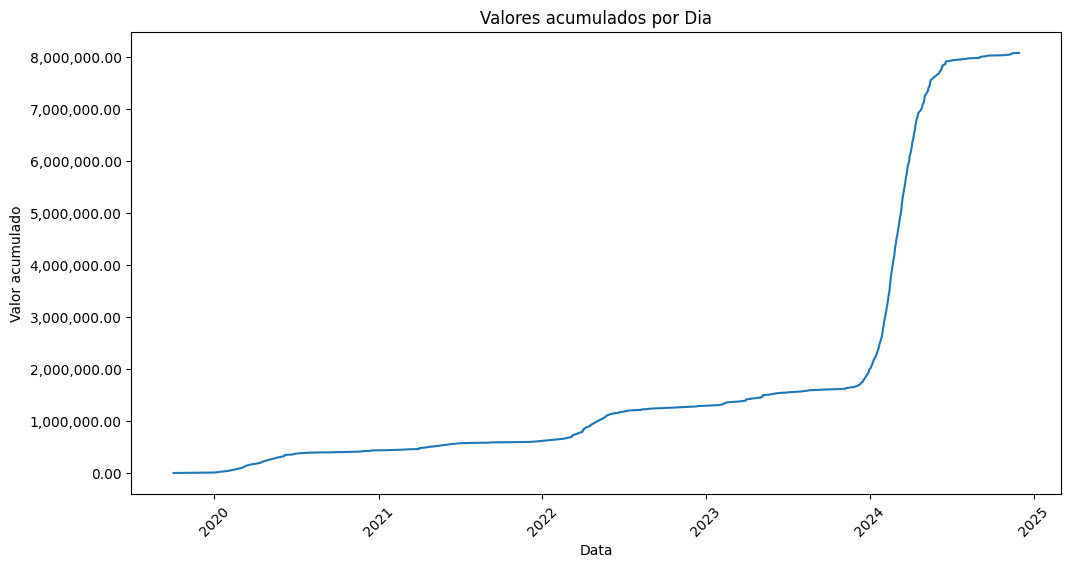

In [469]:
vl_acumulado_diario = sql_query("""
  with a as (
    select dt_saida,
      sum(vl_total) as vl_total
    from dengue_df
    --where ano = 2024
    --and dt_saida >= '2024-01-01'::DATE
    group by all
  )
  select dt_saida,
      sum(vl_total) over (order by dt_saida) as vl_acumulado
    from a
    order by dt_saida
""")

plt.figure(figsize=(12, 6))  # Ajuste o tamanho conforme necessário
sns.lineplot(x='dt_saida', y='vl_acumulado', data=vl_acumulado_diario)
ax = plt.gca()
# Defina o formatador para moeda
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

plt.title('Valores acumulados por Dia')
plt.xlabel('Data')
plt.ylabel('Valor acumulado')
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade, se necessário
plt.show()

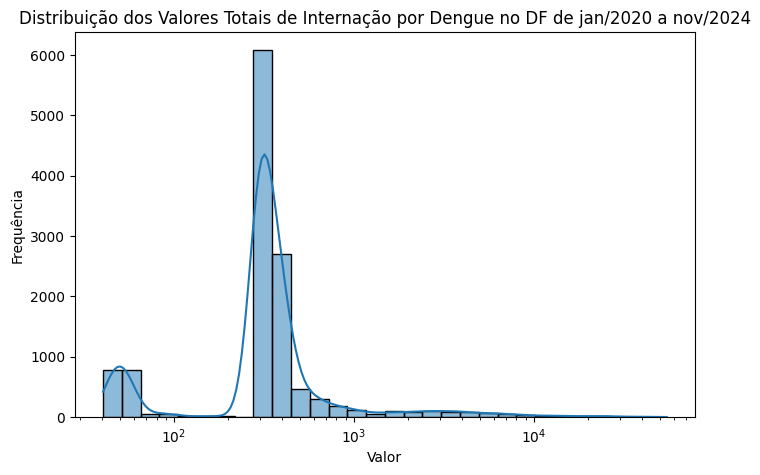

In [444]:
plt.figure(figsize=(8, 5))
sns.histplot(dengue_df['vl_total'], bins=30, kde=True, log_scale=(True, False))
plt.title("Distribuição dos Valores Totais de Internação por Dengue no DF de jan/2020 a nov/2024")
plt.xlabel("Valor")
plt.ylabel("Frequência")
plt.show()

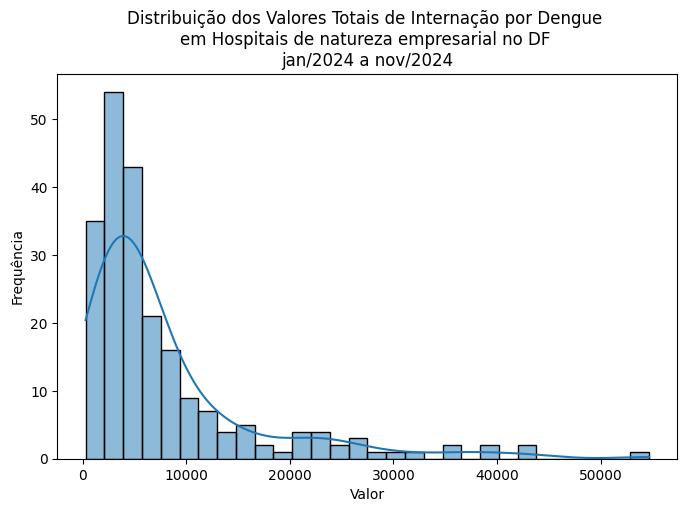

In [445]:
valores = dengue_df[(dengue_df['ano']==2024)&(dengue_df['lg_empresa']==1)]['vl_total']
plt.figure(figsize=(8, 5))
sns.histplot(valores, bins=30, kde=True, log_scale=(False, False))
plt.title("Distribuição dos Valores Totais de Internação por Dengue \nem Hospitais de natureza empresarial no DF \njan/2024 a nov/2024")
plt.xlabel("Valor")
plt.ylabel("Frequência")
plt.show()

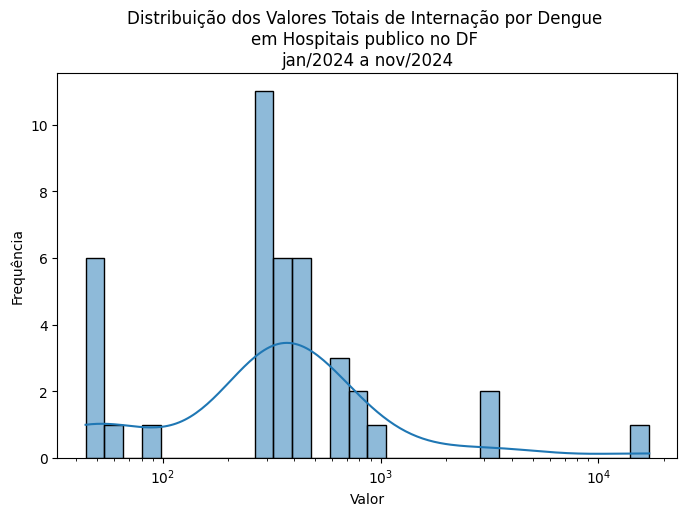

In [446]:
valores = sql_query("""
  with a as (
    SELECT d.*,
      case
        when sum(qt_diarias_uti) over (partition by cd_cnes) > 0
        then 1
        else 0
      end as lg_uti_hosp
    FROM dengue_df d
    where ano = 2024
  )
  select vl_total
  from a
  where lg_uti_hosp = 0
""")
valores = dengue_df[(dengue_df['mes']==7)&(dengue_df['ano']==2024)&(dengue_df['lg_estab_publico']==1)]['vl_total']
plt.figure(figsize=(8, 5))
sns.histplot(valores, bins=30, kde=True, log_scale=(True, False))
plt.title("Distribuição dos Valores Totais de Internação por Dengue \nem Hospitais publico no DF \njan/2024 a nov/2024")
plt.xlabel("Valor")
plt.ylabel("Frequência")
plt.show()

In [447]:
dengue_df[(dengue_df['ano']==2024)&(dengue_df['vl_total']<=100)]

ano  mes cd_especialidade cd_municipio_res cd_sexo  qt_diarias_uti cd_tipo_uti  qt_diarias_uti_interm  qt_diarias_acompanhante  qt_diarias cd_proc_solicitado cd_proc_realizado  vl_sh  vl_sp  vl_total  vl_uti dt_internacao   dt_saida cd_diag_princ cd_motivo_alta_perm cd_natureza_juridica cd_municipio_estab cd_unidade_idade idade  qt_dias_permanencia cd_morte cd_nacionalidade cd_carater_atendimento  cd_cnes cd_complexidade cd_tipo_financiamento cd_raca_cor   especialidade       sexo  lg_masculino          tipo_uti                                   motivo_alta_perm                                  natureza_juridica  lg_estab_publico  lg_empresa unidade_idade  idade_anos  lg_morte  lg_brasileiro carater_atendimento        complexidade               tipo_financiamento raca_cor  lg_preta  lg_mesmo_municipio  lg_hemorragica
3858   2024    1               07           530010       1               0          00                      0                        1           1         0301060010        0301060010  43.65  11.62     55.27     0.0    2024-01-09 2024-01-10           A90                  12                 1023             530010                4    10                    1        0              010                     02  2814897              02                    06          01       Pediatria  Masculino             1  Não utilizou UTI                                     Alta melhorado  Órgão Público do Poder Exec Estadual ou Distr Fed                 1           0          Anos   10.000000         0              1            Urgência  Média complexidade  Média e Alta Complexidade (MAC)   Branca         0                   1               0
3859   2024    1               07           530010       1               0          00                      0                        1           1         0301060010        0301060010  43.65  11.62     55.27     0.0    2024-01-22 2024-01-23           A90                  12                 1023             530010                4     6                    1        0              010                     02  2814897              02                    06          03       Pediatria  Masculino             1  Não utilizou UTI                                     Alta melhorado  Órgão Público do Poder Exec Estadual ou Distr Fed                 1           0          Anos    6.000000         0              1            Urgência  Média complexidade  Média e Alta Complexidade (MAC)    Parda         0                   1               0
3860   2024    1               07           530010       1               0          00                      0                        1           1         0301060010        0301060010  43.65  11.62     55.27     0.0    2024-01-11 2024-01-12           A90                  12                 1023             530010                4    13                    1        0              010                     02  2814897              02                    06          03       Pediatria  Masculino             1  Não utilizou UTI                                     Alta melhorado  Órgão Público do Poder Exec Estadual ou Distr Fed                 1           0          Anos   13.000000         0              1            Urgência  Média complexidade  Média e Alta Complexidade (MAC)    Parda         0                   1               0
3861   2024    1               03           530010       1               0          00                      0                        0           1         0301060088        0301060088  33.34  10.88     44.22     0.0    2024-01-23 2024-01-24           A90                  12                 1023             530010                4    29                    1        0              010                     02  2814897              02                    06          01  Clínica médica  Masculino             1  Não utilizou UTI                                     Alta melhorado  Órgão Público do Poder Exec Estadual ou Distr Fed                 1           0   

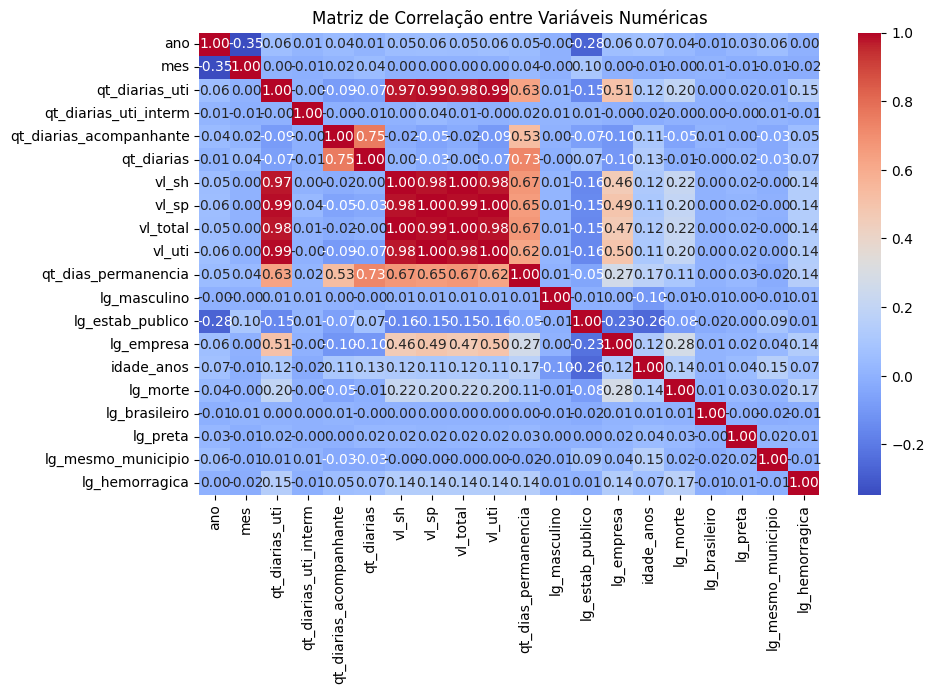

In [448]:
# Matriz de correlação para variáveis numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(dengue_df.select_dtypes(include=['int', 'float']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

In [449]:
from sklearn.model_selection import train_test_split

In [450]:
# Separar variáveis preditoras e alvo

dados_treino = dengue_df[dengue_df['ano']==2020]

X = dados_treino[[
    #'ano',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'qt_diarias_uti',
    #'lg_masculino',
    #'lg_hemorragica',
    #'lg_estab_publico',
    #'lg_empresa',
    #'lg_mesmo_municipio',
    #'idade_anos',
    #'lg_preta'
  ]]
y = dados_treino['vl_total']

#y = dados_treino['qt_diarias_uti']

In [451]:
dados_treino.columns

Index(['ano', 'mes', 'cd_especialidade', 'cd_municipio_res', 'cd_sexo', 'qt_diarias_uti', 'cd_tipo_uti', 'qt_diarias_uti_interm', 'qt_diarias_acompanhante', 'qt_diarias', 'cd_proc_solicitado', 'cd_proc_realizado', 'vl_sh', 'vl_sp', 'vl_total', 'vl_uti', 'dt_internacao', 'dt_saida', 'cd_diag_princ', 'cd_motivo_alta_perm', 'cd_natureza_juridica', 'cd_municipio_estab', 'cd_unidade_idade', 'idade', 'qt_dias_permanencia', 'cd_morte', 'cd_nacionalidade', 'cd_carater_atendimento', 'cd_cnes', 'cd_complexidade', 'cd_tipo_financiamento', 'cd_raca_cor', 'especialidade', 'sexo', 'lg_masculino', 'tipo_uti', 'motivo_alta_perm', 'natureza_juridica', 'lg_estab_publico', 'lg_empresa', 'unidade_idade', 'idade_anos', 'lg_morte', 'lg_brasileiro', 'carater_atendimento', 'complexidade', 'tipo_financiamento', 'raca_cor', 'lg_preta', 'lg_mesmo_municipio', 'lg_hemorragica'], dtype='object')

In [452]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [453]:
# Importar o modelo de regressão linear
from sklearn.linear_model import LinearRegression

In [454]:
sql_query("""
with a as (
  SELECT cd_cnes,
    sum(qt_diarias_uti) as qt_diarias_uti,
    count(1) as qt
  FROM dengue_df
  where ano = 2024
  GROUP BY ALL
) select sum(qt) from a where qt_diarias_uti = 0
  """
  )

sum(qt)
0   1575.0

In [456]:
# Criar e treinar o modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

ValueError: at least one array or dtype is required

In [ ]:
coeficientes = pd.DataFrame(modelo.coef_, X.columns, columns=['Coeficiente'])
coeficientes.sort_values(by='Coeficiente', ascending=False)

In [ ]:
# Importar métricas para avaliação
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = modelo.predict(X_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

In [ ]:
# Importar Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Criar e treinar o modelo de Árvore de Decisão
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

In [ ]:
# Fazer previsões no conjunto de teste
y_pred_tree = tree_model.predict(X_test)

In [ ]:
# Avaliação do modelo de Árvore de Decisão
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

In [ ]:
print(f"Árvore de Decisão - R²: {r2_tree}")
print(f"Árvore de Decisão - MSE: {mse_tree}")
print(f"Árvore de Decisão - RMSE: {rmse_tree}")
print(f"Árvore de Decisão - MAE: {mae_tree}")